In [27]:
import requests
import urllib.request
import pandas as pd
import re
import json
from bs4 import BeautifulSoup
from IPython.display import Image, display

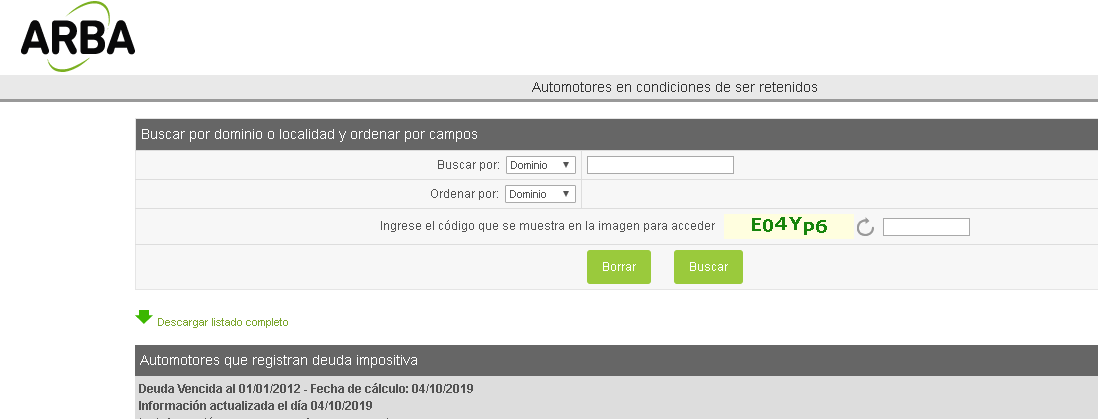

In [2]:
display(Image(filename='web.png'))

In [3]:
url = 'https://www.arba.gov.ar/DominiosRetenidos/DominiosRetenidos.asp?pagina=1&buscarpor=&obj=&Ordenarpor='
path_file_dest = r'data.json'
response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0 (Platform; Security; OS-or-CPU; Localization; rv:1.4) Gecko/20030624 Netscape/7.1 (ax)'})

In [4]:
def write_doc_json(content, mode):
    own_file = open(path_file_dest, mode, encoding='utf-8')
    own_file.write(content.decode('utf-8'))
    own_file.close()
    print('\n•  El archivo json fue sobre-escrito con exito!')

In [5]:
if response.status_code == 200:
    info = []
    soup = BeautifulSoup(response.text, "html.parser")
    data = soup.findAll('td', attrs={'class': 'TituloTabla'})
    paginacion = data[0].get_text().split(' ')[-1]
    
    for x in range (1, int(paginacion) + 1):
        new_url = url.replace('1', str(x))
        new_response = requests.get(new_url, headers={'User-Agent': 'Mozilla/5.0 (Platform; Security; OS-or-CPU; Localization; rv:1.4) Gecko/20030624 Netscape/7.1 (ax)'})
        if new_response.status_code == 200:
            new_soup = BeautifulSoup(new_response.text, "html.parser")
            tabla = new_soup.findAll('table')
            tr = tabla[3].findAll('tr')
      
            for m in range(3, len(tr)):
                td = tr[m].findAll('td', {'class': 'TDtabla'})
                td_ultimo = tr[m].findAll('td', {'class': 'TDultimo'})
                
                individuo = {'Dominio' : td[0].get_text().rstrip().lstrip(), 
                             'Marca' : td[3].get_text().rstrip().lstrip(), 
                             'Localidad' : td_ultimo[0].get_text().rstrip().lstrip()}
        
                info.append(individuo)
            
    content = json.dumps(info, indent=4, sort_keys=True, ensure_ascii=False).encode('utf-8')
    write_doc_json(content ,'w+')

else:
    print('No se pudo conectar')


•  El archivo json fue sobre-escrito con exito!


In [6]:
df_informacion = pd.read_json(path_file_dest, encoding = 'UTF-8')

In [7]:
df_informacion.head()

,Dominio,Localidad,Marca
0,AA000RA,BARADERO,FORD RANGER2 DC 4X2 XL SAFETY 2.2L DSL
1,AA000ZT,VILLA ROSA,RENAULT FLUENCE PH2 1.6 DYNAMIQUE
2,AA002HA,25 DE MAYO,TOYOTA HILUX 4X2 D/C DX 2.4 TDI 6 M/T
3,AA003YI,PILAR,PEUGEOT EXPERT 1.6 HDI CONFORT
4,AA005MX,LIMA,FORD ECOSPORT S 1.6L MT N


In [8]:
df_informacion['Tipo'] = ''

In [9]:
df_informacion['Dominio'] = df_informacion['Dominio'].map(lambda x: x[:3] + ' ' + x[3:6] if len(x) == 6 else x[:2] + ' ' + x[2:5] + ' ' + x[5:7])

In [10]:
df_informacion.head()

,Dominio,Localidad,Marca,Tipo
0,AA 000 RA,BARADERO,FORD RANGER2 DC 4X2 XL SAFETY 2.2L DSL,
1,AA 000 ZT,VILLA ROSA,RENAULT FLUENCE PH2 1.6 DYNAMIQUE,
2,AA 002 HA,25 DE MAYO,TOYOTA HILUX 4X2 D/C DX 2.4 TDI 6 M/T,
3,AA 003 YI,PILAR,PEUGEOT EXPERT 1.6 HDI CONFORT,
4,AA 005 MX,LIMA,FORD ECOSPORT S 1.6L MT N,


In [11]:
df_informacion['Tipo'] = df_informacion['Dominio'].map(lambda x: 'Vieja' if len(x) == 7 else 'Nueva')

In [12]:
df_informacion.head()

,Dominio,Localidad,Marca,Tipo
0,AA 000 RA,BARADERO,FORD RANGER2 DC 4X2 XL SAFETY 2.2L DSL,Nueva
1,AA 000 ZT,VILLA ROSA,RENAULT FLUENCE PH2 1.6 DYNAMIQUE,Nueva
2,AA 002 HA,25 DE MAYO,TOYOTA HILUX 4X2 D/C DX 2.4 TDI 6 M/T,Nueva
3,AA 003 YI,PILAR,PEUGEOT EXPERT 1.6 HDI CONFORT,Nueva
4,AA 005 MX,LIMA,FORD ECOSPORT S 1.6L MT N,Nueva


In [13]:
patentes_viejas = df_informacion['Dominio'][df_informacion['Tipo'] == 'Vieja'].to_list()
len(patentes_viejas)

6077

In [14]:
patentes_nuevas = df_informacion['Dominio'][df_informacion['Tipo'] == 'Nueva'].to_list()
len(patentes_nuevas)

3359

In [15]:
from PIL import Image, ImageDraw, ImageFont
import cv2

In [18]:
patente_vieja = Image.open("modelo/patente.jpg")
patente_nueva = Image.open("modelo/patente_nueva.jpg")

font_vieja = ImageFont.truetype("font/LicensePlate.ttf", 150)
font_nueva = ImageFont.truetype("font/LicensePlate.ttf", 145)

mask = cv2.imread('efecto/oxido.jpg')
mask_vieja = cv2.resize(mask, (patente_vieja.size[0], patente_vieja.size[1]), interpolation=cv2.INTER_AREA)[...,(2,1,0)]
mask_nueva = cv2.resize(mask, (patente_nueva.size[0], patente_nueva.size[1]), interpolation=cv2.INTER_AREA)[...,(2,1,0)]

In [19]:
for x in range (0, len(patentes_viejas)):
    image_temp = patente_vieja.copy()
    draw = ImageDraw.Draw(image_temp)
    draw.text((20, 40), patentes_viejas[x], font=font_vieja, fill="white")
    image_temp.save("patentes/patente_vieja_"+str(x)+".jpg")
    
    image_temp = cv2.imread("patentes/patente_vieja_"+str(x)+".jpg")
    dst = cv2.addWeighted(image_temp, 0.4, mask_vieja, 0.4, 0)
    img_oxido_leve = Image.fromarray(dst)
    img_oxido_leve.save("patentes/patente_vieja_oxido_leve_"+str(x)+".jpg")
    
    res = cv2.bitwise_and(image_temp, mask_vieja)
    img_oxido_fuerte = Image.fromarray(res)
    img_oxido_fuerte.save("patentes/patente_vieja_img_oxido_fuerte_"+str(x)+".jpg")

In [20]:
for x in range (0, len(patentes_nuevas)):
    image_temp = patente_nueva.copy()
    draw = ImageDraw.Draw(image_temp)
    draw.text((16, 50), patentes_nuevas[x], font=font_nueva, fill="black")
    image_temp.save("patentes/patente_nueva_"+str(x)+".jpg")

    image_temp = cv2.imread("patentes/patente_nueva_"+str(x)+".jpg")
    dst = cv2.addWeighted(image_temp, 0.4, mask_nueva, 0.4, 0)
    img_oxido_leve = Image.fromarray(dst)
    img_oxido_leve.save("patentes/patente_nueva_oxido_leve_"+str(x)+".jpg")

    res = cv2.bitwise_and(image_temp, mask_nueva)
    img_oxido_fuerte = Image.fromarray(res)
    img_oxido_fuerte.save("patentes/patente_nueva_img_oxido_fuerte_"+str(x)+".jpg")

In [21]:
import pytesseract
from PIL import Image
pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract'

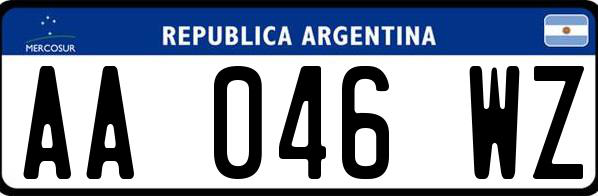

In [22]:
im = Image.open("patentes/patente_nueva_100.jpg")
texto = pytesseract.image_to_string(im)
Image.open("patentes/patente_nueva_100.jpg")

In [23]:
print(texto)

AA 046 WZ


In [24]:
df_informacion[df_informacion.Dominio == texto]

,Dominio,Localidad,Marca,Tipo
100,AA 046 WZ,LOBOS,TOYOTA HILUX 4X2 D/C SRV PACK 2.8 TDI 6,Nueva


In [26]:
import glob
Numero=len(glob.glob("patentes/*.jpg"))
print('Imagenes de patentes generadas usando el DF: ' + str(Numero))

Imagenes de patentes generadas usando el DF: 28308


#### Elimine todas las imágenes que se generaron porque si no la carpeta iba a ser muy pesada. En la imagen que sigue pueden ver el total de patentes generadas y el peso de la carpeta.

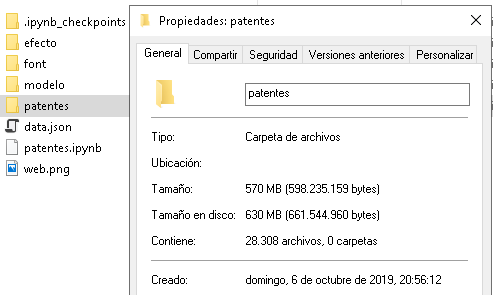

In [28]:
display(Image(filename='imagenes_generadas.png'))